In [2]:
# !pip -q install lightgbm holidays pandas==2.2.2 numpy==1.26.4 scikit-learn==1.5.2 optuna

import os
import random
import math
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from math import sqrt
from datetime import timedelta
import holidays


from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from lightgbm import LGBMRegressor

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


from google.colab import drive
drive.mount('/content/drive')

In [4]:
try:
    df = pd.read_csv('/content/drive/MyDrive/Datos_EESS/merged_df_clean.csv')
    print("CSV file loaded successfully!")
    #display(df.head()) # Display the first 5 rows
except FileNotFoundError:
    print("Error: Make sure the file path is correct.")
except Exception as e:
    print(f"An error occurred: {e}")

Mounted at /content/drive
CSV file loaded successfully!


### MODELO TOTAL

In [7]:
# Configuracion de entradas
DATE_COL = "fecha"
VOLUME_COL_PREFIX = "volumen_"              # columnas de volúmenes empiezan así
H = 7                                       # horizonte directo
LAGS = [7, 14, 30, 60, 90]
ROLLS = [7, 14, 30]
TEST_DAYS = 90
VAL_DAYS  = 90
RANDOM_STATE = 123
N_TRIALS_OPTUNA = 100

# Datos
df =pd.read_csv('/content/drive/MyDrive/Datos_EESS/merged_df_clean.csv')
df[DATE_COL] = pd.to_datetime(df[DATE_COL])
df = df.sort_values(DATE_COL)

vol_cols = [c for c in df.columns if c.startswith(VOLUME_COL_PREFIX)]
if not vol_cols:
    raise ValueError("No se encontraron columnas de volúmenes con el prefijo configurado.")

df_long = df.melt(id_vars=[DATE_COL], value_vars=vol_cols,
                  var_name="serie", value_name="y").sort_values([DATE_COL, "serie"])
# nombre de serie más limpio
df_long["serie"] = df_long["serie"].str.replace(VOLUME_COL_PREFIX, "", regex=False)
df_long["serie"] = df_long["serie"].astype("category")

# variables
def add_calendar_features(d):
    d["year"]          = d[DATE_COL].dt.year.astype("int16")
    d["month"]         = d[DATE_COL].dt.month.astype("int8")
    d["day"]           = d[DATE_COL].dt.day.astype("int8")
    d["dow"]           = d[DATE_COL].dt.weekday.astype("int8")     # 0=lunes
    d["week"]          = d[DATE_COL].dt.isocalendar().week.astype("int16")
    d["quarter"]       = d[DATE_COL].dt.quarter.astype("int8")
    d["is_month_end"]  = d[DATE_COL].dt.is_month_end.astype("int8")
    d["is_month_start"]= d[DATE_COL].dt.is_month_start.astype("int8")
    return d

def add_lag_roll_features(d, lags=LAGS, rolls=ROLLS):
    d = d.sort_values(["serie", DATE_COL]).copy()
    for L in lags:
        d[f"lag_{L}"] = d.groupby("serie")["y"].shift(L)
    for W in rolls:
        # usar shift(1) para no “ver” el presente?
        grp = d.groupby("serie")["y"]
        d[f"roll_mean_{W}"] = grp.shift(1).rolling(W).mean().reset_index(level=0, drop=True)
        d[f"roll_std_{W}"]  = grp.shift(1).rolling(W).std().reset_index(level=0, drop=True)
        d[f"roll_min_{W}"]  = grp.shift(1).rolling(W).min().reset_index(level=0, drop=True)
        d[f"roll_max_{W}"]  = grp.shift(1).rolling(W).max().reset_index(level=0, drop=True)
    return d

# Features base
df_feat = add_calendar_features(df_long.copy())
df_feat = add_lag_roll_features(df_feat, lags=LAGS, rolls=ROLLS)


In [8]:
df_feat

fecha serie            y  year  month  day  dow  week  quarter  \
0    2022-04-01   DSP  8250.661415  2022      4    1    4    13        2   
1    2022-04-02   DSP  6217.523570  2022      4    2    5    13        2   
2    2022-04-03   DSP  6930.748854  2022      4    3    6    13        2   
3    2022-04-04   DSP  5653.462986  2022      4    4    0    14        2   
4    2022-04-05   DSP  8928.674663  2022      4    5    1    14        2   
...         ...   ...          ...   ...    ...  ...  ...   ...      ...   
2199 2025-04-02   NFP  1790.127405  2025      4    2    2    14        2   
2200 2025-04-03   NFP  2153.394810  2025      4    3    3    14        2   
2201 2025-04-04   NFP  2454.637897  2025      4    4    4    14        2   
2202 2025-04-05   NFP  1604.036352  2025      4    5    5    14        2   
2203 2025-04-06   NFP   907.718181  2025      4    6    6    14        2   

      is_month_end  ...    roll_min_7    roll_max_7  roll_mean_14  \
0                0  ...           NaN           NaN           NaN   
1                0  ...           NaN           NaN           NaN   
2                0  ...           NaN           NaN           NaN   
3                0  ...           NaN           NaN           NaN   
4                0  ...           NaN           NaN           NaN   
...            ...  ...           ...           ...           ...   
2199             0  ...  11378.170575  16207.624995  14637.251301   
2200             0  ...  11378.170575  16207.624995  14524.586818   
2201             0  ...  11378.170575  18780.474280  14544.150248   
2202             0  ...  11378.170575  18780.474280  14461.147814   
2203             0  ...  11378.170575  18780.474280  14480.933397   

      roll_std_14   roll_min_14   roll_max_14  roll_mean_30  roll_std_30  \
0             NaN           NaN           NaN           NaN          NaN   
1             NaN           NaN           NaN           NaN          NaN   
2             NaN           NaN           NaN           NaN          NaN   
3             NaN           NaN           NaN           NaN          NaN   
4             NaN           NaN           NaN           NaN          NaN   
...           ...           ...           ...           ...          ...   
2199  2020.692416  11378.170575  18506.586269  13910.455014  2733.435809   
2200  2060.136493  11378.170575  18506.586269  14034.745427  2602.940219   
2201  2101.739409  11378.170575  18780.474280  14348.956397  2587.341222   
2202  2060.875063  11378.170575  18780.474280  14540.200252  2393.499231   
2203  2070.821465  11378.170575  18780.474280  14504.173968  2368.579502   

      roll_min_30   roll_max_30  
0             NaN           NaN  
1             NaN           NaN  
2             NaN           NaN  
3             NaN           NaN  
4             NaN           NaN  
...           ...           ...  
2199  7340.969386  18506.586269  
2200  7340.969386  18506.586269  
2201  7340.969386  18780.474280  
2202  7340.969386  18780.474280  
2203  7340.969386  18780.474280  

[3306 rows x 28 columns]

In [9]:
df_feat = df_feat.sort_values(["serie", DATE_COL])
# y_{t+H} como target directo por serie
df_feat["y_h7"] = df_feat.groupby("serie")["y"].shift(-H)
# fecha objetivo para graficar luego
df_feat["fecha_objetivo"] = df_feat[DATE_COL] + pd.to_timedelta(H, unit="D")

# Cortes: eliminar cabeceras por lags/rollings y colas por horizonte
min_lag = max(LAGS + ROLLS)  # 90
def _trim(g):
    # g viene ordenado; quitamos primeras min_lag filas y últimas H filas (sin target)
    g = g.iloc[min_lag:].copy()
    if len(g) > H:
        g = g.iloc[:-H].copy()
    else:
        g = g.iloc[0:0]  # vacío si no alcanza
    return g

df_feat = df_feat.groupby("serie", group_keys=False).apply(_trim).reset_index(drop=True)

# Split
last_target_date = df_feat["fecha_objetivo"].max()
test_start = last_target_date - pd.Timedelta(days=TEST_DAYS-1)
val_start  = test_start - pd.Timedelta(days=VAL_DAYS)

train_mask = df_feat["fecha_objetivo"] < val_start
val_mask   = (df_feat["fecha_objetivo"] >= val_start) & (df_feat["fecha_objetivo"] < test_start)
test_mask  = df_feat["fecha_objetivo"] >= test_start

# Categóricas comunes
features_cat = ["serie","dow","month","quarter","is_month_end","is_month_start","week"]
for c in features_cat:
    df_feat[c] = df_feat[c].astype("category")

# Columnas de features
feature_cols = [c for c in df_feat.columns if c not in [DATE_COL, "y", "y_h7", "fecha_objetivo"]]

Xtr, ytr = df_feat.loc[train_mask, feature_cols], df_feat.loc[train_mask, "y_h7"]
Xva, yva = df_feat.loc[val_mask,   feature_cols], df_feat.loc[val_mask,   "y_h7"]
Xte, yte = df_feat.loc[test_mask,  feature_cols], df_feat.loc[test_mask,  "y_h7"]

categorical_feature = [Xtr.columns.get_loc(c) for c in features_cat if c in Xtr.columns]

In [10]:
# Entrenamiento base + Optuna

def rmse(y_true, y_pred):
    """Calcula el RMSE sin usar el parámetro 'squared' (compatibilidad sklearn < 0.22)."""
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def metrics(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse_val = rmse(y_true, y_pred)  # ← usa la función rmse() recién definida
    denom = np.where(y_true == 0, np.nan, y_true)
    mape = np.nanmean(np.abs((y_true - y_pred) / denom)) * 100
    return {"MAE": mae, "RMSE": rmse_val, "MAPE_%": mape}
# ver de la pagina de stack overflow!!!
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 500, 4000),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.2, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 31, 511),
        "max_depth": trial.suggest_int("max_depth", -1, 16),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 200),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 3.0),
        "random_state": RANDOM_STATE
    }
    model = lgb.LGBMRegressor(**params)
    model.fit(
        Xtr, ytr,
        eval_set=[(Xva, yva)],
        eval_metric="rmse",
        categorical_feature=categorical_feature,
        callbacks=[lgb.early_stopping(stopping_rounds=200, verbose=False)]
    )
    pred_va = model.predict(Xva)
    return rmse(yva, pred_va)

study = optuna.create_study(direction="minimize", study_name="lgbm_direct_h7")
study.optimize(objective, n_trials=N_TRIALS_OPTUNA, show_progress_bar=False)

best_params = study.best_trial.params.copy()
best_params.update(dict(random_state=RANDOM_STATE))

# Modelo final con train+val y evaluación en test
final_model = lgb.LGBMRegressor(**best_params)
Xtrva = pd.concat([Xtr, Xva], axis=0)
ytrva = pd.concat([ytr, yva], axis=0)

# final_model.fit(
#     Xtrva, ytrva,
#     eval_set=[(Xte, yte)],
#     eval_metric="rmse",
#     categorical_feature=categorical_feature,
#     callbacks=[lgb.early_stopping(stopping_rounds=300, verbose=False)]
# )
final_model.fit(
    Xtrva, ytrva,
    categorical_feature=categorical_feature
)

[I 2025-10-20 23:27:17,733] A new study created in memory with name: lgbm_direct_h7


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000783 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4140
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 26
[LightGBM] [Info] Start training from score 7371.641832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-10-20 23:27:18,255] Trial 0 finished with value: 1643.8380416543744 and parameters: {'n_estimators': 4000, 'learning_rate': 0.03809674912350866, 'num_leaves': 443, 'max_depth': 0, 'min_child_samples': 68, 'subsample': 0.7107472304456822, 'colsample_bytree': 0.6091786621883263, 'reg_alpha': 0.5007512028504529, 'reg_lambda': 0.112288327478417}. Best is trial 0 with value: 1643.8380416543744.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:27:18,436] Trial 1 finished with value: 1642.1645012454278 and parameters: {'n_estimators': 795, 'learning_rate': 0.13823779306366482, 'num_leaves': 343, 'max_depth': 4, 'min_child_samples': 87, 'subsample': 0.7766961091543517, 'colsample_bytree': 0.7862180981173772, 'reg_alpha': 0.8234356799084422, 'reg_lambda': 2.13604799013455}. Best is trial 1 with value: 1642.1645012454278.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:27:18,984] Trial 2 finished with value: 1644.1820902768754 and parameters: {'n_estimators': 1730, 'learning_rate': 0.008884940490224404, 'num_leaves': 230, 'max_depth': 12, 'min_child_samples': 166, 'subsample': 0.6832485372694616, 'colsample_bytree': 0.9467700851705194, 'reg_alpha': 0.9573394883698996, 'reg_lambda': 2.4654286057714723}. Best is trial 1 with value: 1642.1645012454278.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:27:19,624] Trial 3 finished with value: 1641.0103071842861 and parameters: {'n_estimators': 1065, 'learning_rate': 0.014906015139124661, 'num_leaves': 90, 'max_depth': 12, 'min_child_samples': 50, 'subsample': 0.9828458054096617, 'colsample_bytree': 0.6260855860744939, 'reg_alpha': 0.49994019116494304, 'reg_lambda': 2.566497101093724}. Best is trial 3 with value: 1641.0103071842861.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4140
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 26
[LightGBM] [Info] Start training from score 7371.641832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-10-20 23:27:19,899] Trial 4 finished with value: 1639.3753675385842 and parameters: {'n_estimators': 1322, 'learning_rate': 0.0515668282782131, 'num_leaves': 267, 'max_depth': 16, 'min_child_samples': 138, 'subsample': 0.9954739008383587, 'colsample_bytree': 0.6784933564970165, 'reg_alpha': 0.3004876874384783, 'reg_lambda': 1.7838636254656541}. Best is trial 4 with value: 1639.3753675385842.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:27:20,239] Trial 5 finished with value: 1648.7519490450056 and parameters: {'n_estimators': 3051, 'learning_rate': 0.012367338043906165, 'num_leaves': 288, 'max_depth': 3, 'min_child_samples': 41, 'subsample': 0.7080301402961223, 'colsample_bytree': 0.8847826997180375, 'reg_alpha': 0.9579469411239795, 'reg_lambda': 2.4669176532148436}. Best is trial 4 with value: 1639.3753675385842.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:27:20,574] Trial 6 finished with value: 1640.3585254111513 and parameters: {'n_estimators': 3473, 'learning_rate': 0.03661833445380657, 'num_leaves': 494, 'max_depth': 0, 'min_child_samples': 148, 'subsample': 0.7461554182789635, 'colsample_bytree': 0.9431148714790669, 'reg_alpha': 0.5388729215329628, 'reg_lambda': 1.3567986850550198}. Best is trial 4 with value: 1639.3753675385842.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:27:21,043] Trial 7 finished with value: 1658.2135707379 and parameters: {'n_estimators': 2903, 'learning_rate': 0.052655434968573195, 'num_leaves': 435, 'max_depth': 7, 'min_child_samples': 21, 'subsample': 0.7259826419284025, 'colsample_bytree': 0.7583579578081097, 'reg_alpha': 0.8139008942812946, 'reg_lambda': 0.5243069425276986}. Best is trial 4 with value: 1639.3753675385842.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:27:24,020] Trial 8 finished with value: 1615.2134345785435 and parameters: {'n_estimators': 2402, 'learning_rate': 0.00660813269756638, 'num_leaves': 482, 'max_depth': 6, 'min_child_samples': 31, 'subsample': 0.8597250065738344, 'colsample_bytree': 0.7491519795474209, 'reg_alpha': 0.7652813430759875, 'reg_lambda': 2.987536596035226}. Best is trial 8 with value: 1615.2134345785435.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4140
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 26
[LightGBM] [Info] Start training from score 7371.641832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-10-20 23:27:24,367] Trial 9 finished with value: 1667.1918900679732 and parameters: {'n_estimators': 1296, 'learning_rate': 0.015138431269903363, 'num_leaves': 276, 'max_depth': 2, 'min_child_samples': 134, 'subsample': 0.6403427128690174, 'colsample_bytree': 0.7896074899372405, 'reg_alpha': 0.33852867554984634, 'reg_lambda': 0.9727852754111099}. Best is trial 8 with value: 1615.2134345785435.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:27:26,359] Trial 10 finished with value: 1621.1288885540869 and parameters: {'n_estimators': 2218, 'learning_rate': 0.005252928553378516, 'num_leaves': 31, 'max_depth': 8, 'min_child_samples': 7, 'subsample': 0.8742529899642576, 'colsample_bytree': 0.7007721753334059, 'reg_alpha': 0.08011134541228404, 'reg_lambda': 2.9251213187872693}. Best is trial 8 with value: 1615.2134345785435.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4140
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 26
[LightGBM] [Info] Start training from score 7371.641832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-10-20 23:27:28,172] Trial 11 finished with value: 1623.3911967140023 and parameters: {'n_estimators': 2250, 'learning_rate': 0.0050067351929284345, 'num_leaves': 32, 'max_depth': 8, 'min_child_samples': 15, 'subsample': 0.8784105277671793, 'colsample_bytree': 0.7094641464278404, 'reg_alpha': 0.21873251170603702, 'reg_lambda': 2.952275272556207}. Best is trial 8 with value: 1615.2134345785435.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4140
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 26
[LightGBM] [Info] Start training from score 7371.641832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-10-20 23:27:30,604] Trial 12 finished with value: 1618.1356686841373 and parameters: {'n_estimators': 2197, 'learning_rate': 0.005366261469847003, 'num_leaves': 164, 'max_depth': 7, 'min_child_samples': 10, 'subsample': 0.8714456981755965, 'colsample_bytree': 0.7003734701259475, 'reg_alpha': 0.019992992623073372, 'reg_lambda': 2.939891323164472}. Best is trial 8 with value: 1615.2134345785435.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4140
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 26
[LightGBM] [Info] Start training from score 7371.641832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-10-20 23:27:31,336] Trial 13 finished with value: 1619.8728118212994 and parameters: {'n_estimators': 2157, 'learning_rate': 0.00842926730298282, 'num_leaves': 151, 'max_depth': 6, 'min_child_samples': 104, 'subsample': 0.8482152451566288, 'colsample_bytree': 0.8714340422943353, 'reg_alpha': 0.01914578356636115, 'reg_lambda': 1.9205182805481977}. Best is trial 8 with value: 1615.2134345785435.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:27:32,081] Trial 14 finished with value: 1633.8629207211427 and parameters: {'n_estimators': 2716, 'learning_rate': 0.02285797444306003, 'num_leaves': 164, 'max_depth': 11, 'min_child_samples': 41, 'subsample': 0.930019348323341, 'colsample_bytree': 0.8489976097726544, 'reg_alpha': 0.656183621193098, 'reg_lambda': 1.3875406106202304}. Best is trial 8 with value: 1615.2134345785435.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4140
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 26
[LightGBM] [Info] Start training from score 7371.641832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-10-20 23:27:33,000] Trial 15 finished with value: 1618.881109393003 and parameters: {'n_estimators': 1745, 'learning_rate': 0.007562839130833721, 'num_leaves': 344, 'max_depth': 10, 'min_child_samples': 75, 'subsample': 0.8247202357614332, 'colsample_bytree': 0.748765512090339, 'reg_alpha': 0.7008192936331209, 'reg_lambda': 2.9807154911923672}. Best is trial 8 with value: 1615.2134345785435.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000675 secon

[I 2025-10-20 23:27:33,234] Trial 16 finished with value: 1642.9551725392269 and parameters: {'n_estimators': 2721, 'learning_rate': 0.11716307116217817, 'num_leaves': 188, 'max_depth': 6, 'min_child_samples': 107, 'subsample': 0.9223814766277947, 'colsample_bytree': 0.6581899974405571, 'reg_alpha': 0.15425975379552131, 'reg_lambda': 2.2244947299756337}. Best is trial 8 with value: 1615.2134345785435.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:27:33,596] Trial 17 finished with value: 1657.0766892420029 and parameters: {'n_estimators': 1789, 'learning_rate': 0.022859956609562245, 'num_leaves': 371, 'max_depth': 15, 'min_child_samples': 188, 'subsample': 0.7908445456921128, 'colsample_bytree': 0.8225461442864272, 'reg_alpha': 0.4015517380868441, 'reg_lambda': 2.6427420216510105}. Best is trial 8 with value: 1615.2134345785435.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:27:34,535] Trial 18 finished with value: 1626.5020471528765 and parameters: {'n_estimators': 3475, 'learning_rate': 0.007134146733376633, 'num_leaves': 105, 'max_depth': 5, 'min_child_samples': 32, 'subsample': 0.9250502726694659, 'colsample_bytree': 0.7231043233714238, 'reg_alpha': 0.6696668277435269, 'reg_lambda': 1.7433273390831996}. Best is trial 8 with value: 1615.2134345785435.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:27:35,553] Trial 19 finished with value: 1630.584092652359 and parameters: {'n_estimators': 2529, 'learning_rate': 0.010916697927429324, 'num_leaves': 214, 'max_depth': 9, 'min_child_samples': 60, 'subsample': 0.8816977460947182, 'colsample_bytree': 0.9981502232037887, 'reg_alpha': 0.8277260259866062, 'reg_lambda': 0.9486914867758719}. Best is trial 8 with value: 1615.2134345785435.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:27:35,839] Trial 20 finished with value: 1651.5141094079129 and parameters: {'n_estimators': 3374, 'learning_rate': 0.09114058783748456, 'num_leaves': 506, 'max_depth': 3, 'min_child_samples': 5, 'subsample': 0.8267384145392249, 'colsample_bytree': 0.6705010007599921, 'reg_alpha': 0.5583909083819505, 'reg_lambda': 2.2195214653899917}. Best is trial 8 with value: 1615.2134345785435.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4140
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 26
[LightGBM] [Info] Start training from score 7371.641832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-10-20 23:27:37,504] Trial 21 finished with value: 1624.0181203362463 and parameters: {'n_estimators': 1813, 'learning_rate': 0.006735985065097754, 'num_leaves': 368, 'max_depth': 10, 'min_child_samples': 68, 'subsample': 0.8240036503174804, 'colsample_bytree': 0.7490409792406005, 'reg_alpha': 0.7185983170114356, 'reg_lambda': 2.994836894273631}. Best is trial 8 with value: 1615.2134345785435.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4140
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 26
[LightGBM] [Info] Start training from score 7371.641832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-10-20 23:27:39,044] Trial 22 finished with value: 1617.0990516479128 and parameters: {'n_estimators': 1943, 'learning_rate': 0.0067895521087639795, 'num_leaves': 438, 'max_depth': 13, 'min_child_samples': 84, 'subsample': 0.766249729906577, 'colsample_bytree': 0.7526160612690602, 'reg_alpha': 0.7302490837198939, 'reg_lambda': 2.7965145486433505}. Best is trial 8 with value: 1615.2134345785435.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4140
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 26
[LightGBM] [Info] Start training from score 7371.641832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-10-20 23:27:41,971] Trial 23 finished with value: 1623.4208801145567 and parameters: {'n_estimators': 2446, 'learning_rate': 0.0050246759723715385, 'num_leaves': 463, 'max_depth': 14, 'min_child_samples': 26, 'subsample': 0.7701082536743932, 'colsample_bytree': 0.8169542521305764, 'reg_alpha': 0.8895009587828674, 'reg_lambda': 2.6954376858012155}. Best is trial 8 with value: 1615.2134345785435.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4140
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 26
[LightGBM] [Info] Start training from score 7371.641832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-10-20 23:27:42,614] Trial 24 finished with value: 1620.4610007239319 and parameters: {'n_estimators': 1953, 'learning_rate': 0.021067449317947174, 'num_leaves': 398, 'max_depth': 13, 'min_child_samples': 51, 'subsample': 0.9002783479395394, 'colsample_bytree': 0.6464501025539959, 'reg_alpha': 0.6079584224965446, 'reg_lambda': 2.7125211812222205}. Best is trial 8 with value: 1615.2134345785435.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:27:43,301] Trial 25 finished with value: 1614.763560337744 and parameters: {'n_estimators': 1374, 'learning_rate': 0.011570502925658335, 'num_leaves': 410, 'max_depth': 7, 'min_child_samples': 87, 'subsample': 0.6049287661513166, 'colsample_bytree': 0.7525718998140145, 'reg_alpha': 0.7421433118649549, 'reg_lambda': 2.339470525819915}. Best is trial 25 with value: 1614.763560337744.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4140
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 26
[LightGBM] [Info] Start training from score 7371.641832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-10-20 23:27:43,829] Trial 26 finished with value: 1616.5262904896495 and parameters: {'n_estimators': 505, 'learning_rate': 0.010967995189701126, 'num_leaves': 402, 'max_depth': 5, 'min_child_samples': 91, 'subsample': 0.6305433532128057, 'colsample_bytree': 0.7728342885740204, 'reg_alpha': 0.7574942493783158, 'reg_lambda': 2.3449866955420093}. Best is trial 25 with value: 1614.763560337744.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:27:44,402] Trial 27 finished with value: 1639.4777424870692 and parameters: {'n_estimators': 542, 'learning_rate': 0.01102721662862868, 'num_leaves': 407, 'max_depth': 5, 'min_child_samples': 114, 'subsample': 0.6046874964124734, 'colsample_bytree': 0.779852490027008, 'reg_alpha': 0.7768203959988323, 'reg_lambda': 2.2807015760152587}. Best is trial 25 with value: 1614.763560337744.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4140
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 26
[LightGBM] [Info] Start training from score 7371.641832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-10-20 23:27:44,652] Trial 28 finished with value: 1670.5523054241705 and parameters: {'n_estimators': 1450, 'learning_rate': 0.017075898540199107, 'num_leaves': 471, 'max_depth': 2, 'min_child_samples': 89, 'subsample': 0.6498349819366558, 'colsample_bytree': 0.831486183425467, 'reg_alpha': 0.8836182567824473, 'reg_lambda': 2.002852425427958}. Best is trial 25 with value: 1614.763560337744.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:27:45,067] Trial 29 finished with value: 1637.5466976892467 and parameters: {'n_estimators': 520, 'learning_rate': 0.02930766028160386, 'num_leaves': 326, 'max_depth': -1, 'min_child_samples': 119, 'subsample': 0.6005543895941109, 'colsample_bytree': 0.7749932983998529, 'reg_alpha': 0.44702520323347505, 'reg_lambda': 2.4107626284013977}. Best is trial 25 with value: 1614.763560337744.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:27:45,657] Trial 30 finished with value: 1622.8108235859572 and parameters: {'n_estimators': 946, 'learning_rate': 0.01021000398387568, 'num_leaves': 398, 'max_depth': 5, 'min_child_samples': 96, 'subsample': 0.6370779392396586, 'colsample_bytree': 0.7323443344636702, 'reg_alpha': 0.6218510796965188, 'reg_lambda': 1.5570390386048565}. Best is trial 25 with value: 1614.763560337744.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:27:46,673] Trial 31 finished with value: 1610.0501288154542 and parameters: {'n_estimators': 1420, 'learning_rate': 0.006986892656367557, 'num_leaves': 436, 'max_depth': 9, 'min_child_samples': 79, 'subsample': 0.6808385330742761, 'colsample_bytree': 0.7546029256189772, 'reg_alpha': 0.7525691874146406, 'reg_lambda': 2.7483551341410504}. Best is trial 31 with value: 1610.0501288154542.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:27:47,437] Trial 32 finished with value: 1625.1776359823004 and parameters: {'n_estimators': 781, 'learning_rate': 0.012976042603960536, 'num_leaves': 466, 'max_depth': 9, 'min_child_samples': 77, 'subsample': 0.6742671294775293, 'colsample_bytree': 0.7989986240866288, 'reg_alpha': 0.7775038043198259, 'reg_lambda': 2.039524838541349}. Best is trial 31 with value: 1610.0501288154542.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4140
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 26
[LightGBM] [Info] Start training from score 7371.641832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-10-20 23:27:47,712] Trial 33 finished with value: 1645.1348454403662 and parameters: {'n_estimators': 1148, 'learning_rate': 0.19387752563657348, 'num_leaves': 422, 'max_depth': 6, 'min_child_samples': 63, 'subsample': 0.6743766408468159, 'colsample_bytree': 0.730617305101519, 'reg_alpha': 0.9061240126227246, 'reg_lambda': 0.0896560958658148}. Best is trial 31 with value: 1610.0501288154542.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4140
[LightGBM] [Info] Number of data points in the train set: 2475, n

[I 2025-10-20 23:27:48,239] Trial 34 finished with value: 1636.1532589731496 and parameters: {'n_estimators': 1513, 'learning_rate': 0.009086530141989114, 'num_leaves': 479, 'max_depth': 4, 'min_child_samples': 97, 'subsample': 0.6278121539484086, 'colsample_bytree': 0.6011345272211128, 'reg_alpha': 0.7563985406680747, 'reg_lambda': 2.365542077277755}. Best is trial 31 with value: 1610.0501288154542.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:27:48,670] Trial 35 finished with value: 1638.0105360948846 and parameters: {'n_estimators': 818, 'learning_rate': 0.017100586411284507, 'num_leaves': 374, 'max_depth': 9, 'min_child_samples': 125, 'subsample': 0.7005146128256301, 'colsample_bytree': 0.7701501128662114, 'reg_alpha': 0.9885642239052728, 'reg_lambda': 2.515659362234968}. Best is trial 31 with value: 1610.0501288154542.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:27:50,050] Trial 36 finished with value: 1616.2387939333867 and parameters: {'n_estimators': 1556, 'learning_rate': 0.006377789487778371, 'num_leaves': 305, 'max_depth': 7, 'min_child_samples': 81, 'subsample': 0.6596324824280477, 'colsample_bytree': 0.8068337780197997, 'reg_alpha': 0.847444879010594, 'reg_lambda': 2.740485754868201}. Best is trial 31 with value: 1610.0501288154542.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4140
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 26
[LightGBM] [Info] Start training from score 7371.641832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-10-20 23:27:51,953] Trial 37 finished with value: 1635.1119212419246 and parameters: {'n_estimators': 1566, 'learning_rate': 0.006530880848264029, 'num_leaves': 305, 'max_depth': 7, 'min_child_samples': 56, 'subsample': 0.6622576337316952, 'colsample_bytree': 0.8585749710305575, 'reg_alpha': 0.8425129431405022, 'reg_lambda': 2.7932983139608707}. Best is trial 31 with value: 1610.0501288154542.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4140
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 26
[LightGBM] [Info] Start training from score 7371.641832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-10-20 23:27:53,724] Trial 38 finished with value: 1643.8848465954388 and parameters: {'n_estimators': 1203, 'learning_rate': 0.00872078110087705, 'num_leaves': 343, 'max_depth': 11, 'min_child_samples': 42, 'subsample': 0.6917536088979992, 'colsample_bytree': 0.8975498143874663, 'reg_alpha': 0.9307085824378973, 'reg_lambda': 2.5415649637173043}. Best is trial 31 with value: 1610.0501288154542.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4140
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 26
[LightGBM] [Info] Start training from score 7371.641832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-10-20 23:27:54,495] Trial 39 finished with value: 1640.62998469635 and parameters: {'n_estimators': 1616, 'learning_rate': 0.0060807749952827795, 'num_leaves': 235, 'max_depth': 8, 'min_child_samples': 159, 'subsample': 0.7293987901387238, 'colsample_bytree': 0.8085581480298225, 'reg_alpha': 0.8460447922568719, 'reg_lambda': 2.762607985696308}. Best is trial 31 with value: 1610.0501288154542.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:27:54,967] Trial 40 finished with value: 1620.3862124439997 and parameters: {'n_estimators': 979, 'learning_rate': 0.05236128287222874, 'num_leaves': 506, 'max_depth': 10, 'min_child_samples': 78, 'subsample': 0.6190181618094236, 'colsample_bytree': 0.9187078846420643, 'reg_alpha': 0.5880672043051538, 'reg_lambda': 2.5701968318459314}. Best is trial 31 with value: 1610.0501288154542.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:27:55,623] Trial 41 finished with value: 1621.789637159142 and parameters: {'n_estimators': 1365, 'learning_rate': 0.008220162639122527, 'num_leaves': 453, 'max_depth': 4, 'min_child_samples': 89, 'subsample': 0.6560295487775946, 'colsample_bytree': 0.793538645933749, 'reg_alpha': 0.6692496372085095, 'reg_lambda': 2.327517678765239}. Best is trial 31 with value: 1610.0501288154542.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:27:56,227] Trial 42 finished with value: 1628.8636313182833 and parameters: {'n_estimators': 751, 'learning_rate': 0.013579080516209019, 'num_leaves': 421, 'max_depth': 6, 'min_child_samples': 66, 'subsample': 0.6201564770307356, 'colsample_bytree': 0.689445893373155, 'reg_alpha': 0.7891313000851186, 'reg_lambda': 2.819396355634441}. Best is trial 31 with value: 1610.0501288154542.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:27:56,940] Trial 43 finished with value: 1619.5841612012587 and parameters: {'n_estimators': 2438, 'learning_rate': 0.009886917436443354, 'num_leaves': 390, 'max_depth': 7, 'min_child_samples': 108, 'subsample': 0.7299087012962111, 'colsample_bytree': 0.8441486169612326, 'reg_alpha': 0.48316285298880723, 'reg_lambda': 2.11214063621272}. Best is trial 31 with value: 1610.0501288154542.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4140
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 26
[LightGBM] [Info] Start training from score 7371.641832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-10-20 23:27:57,473] Trial 44 finished with value: 1648.8684751277144 and parameters: {'n_estimators': 1950, 'learning_rate': 0.005850222113883566, 'num_leaves': 252, 'max_depth': 3, 'min_child_samples': 133, 'subsample': 0.9584784134652247, 'colsample_bytree': 0.7208311734790092, 'reg_alpha': 0.866972849137475, 'reg_lambda': 2.474986451824436}. Best is trial 31 with value: 1610.0501288154542.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:27:58,175] Trial 45 finished with value: 1633.3550238116438 and parameters: {'n_estimators': 1086, 'learning_rate': 0.011689642462083783, 'num_leaves': 443, 'max_depth': 8, 'min_child_samples': 97, 'subsample': 0.6441924781392161, 'colsample_bytree': 0.7662866178874417, 'reg_alpha': 0.9572067566008807, 'reg_lambda': 2.6429595876207146}. Best is trial 31 with value: 1610.0501288154542.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:27:58,995] Trial 46 finished with value: 1617.6303140521456 and parameters: {'n_estimators': 2074, 'learning_rate': 0.007387553307624365, 'num_leaves': 305, 'max_depth': 5, 'min_child_samples': 84, 'subsample': 0.6797586156686863, 'colsample_bytree': 0.7399023710324935, 'reg_alpha': 0.739993334248242, 'reg_lambda': 0.2707987918590744}. Best is trial 31 with value: 1610.0501288154542.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:27:59,616] Trial 47 finished with value: 1629.1104794648365 and parameters: {'n_estimators': 1301, 'learning_rate': 0.014458240994834797, 'num_leaves': 482, 'max_depth': 7, 'min_child_samples': 72, 'subsample': 0.7119281123365454, 'colsample_bytree': 0.7865950306296341, 'reg_alpha': 0.6915630916984236, 'reg_lambda': 1.7787514036330685}. Best is trial 31 with value: 1610.0501288154542.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:27:59,895] Trial 48 finished with value: 1652.2843714386968 and parameters: {'n_estimators': 3880, 'learning_rate': 0.07178594429446342, 'num_leaves': 351, 'max_depth': 4, 'min_child_samples': 45, 'subsample': 0.7501975968338166, 'colsample_bytree': 0.712893480761143, 'reg_alpha': 0.8120873129588391, 'reg_lambda': 2.8947482532757087}. Best is trial 31 with value: 1610.0501288154542.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4140
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 26
[LightGBM] [Info] Start training from score 7371.641832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-10-20 23:28:00,460] Trial 49 finished with value: 1694.0213883516349 and parameters: {'n_estimators': 1635, 'learning_rate': 0.0058491228499672225, 'num_leaves': 418, 'max_depth': 1, 'min_child_samples': 124, 'subsample': 0.6140165524249075, 'colsample_bytree': 0.8031585119649688, 'reg_alpha': 0.9324895446380232, 'reg_lambda': 0.8970823785005051}. Best is trial 31 with value: 1610.0501288154542.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:28:01,337] Trial 50 finished with value: 1630.1393193993686 and parameters: {'n_estimators': 2897, 'learning_rate': 0.017232740596945614, 'num_leaves': 381, 'max_depth': 9, 'min_child_samples': 36, 'subsample': 0.8547948692149877, 'colsample_bytree': 0.6899559607790818, 'reg_alpha': 0.6378599576925873, 'reg_lambda': 2.5903896702465414}. Best is trial 31 with value: 1610.0501288154542.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:28:02,351] Trial 51 finished with value: 1614.931025365659 and parameters: {'n_estimators': 1982, 'learning_rate': 0.007519721493009838, 'num_leaves': 444, 'max_depth': 16, 'min_child_samples': 88, 'subsample': 0.6316089217127203, 'colsample_bytree': 0.7553653566042033, 'reg_alpha': 0.7284039175949883, 'reg_lambda': 2.886250889240955}. Best is trial 31 with value: 1610.0501288154542.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:28:03,214] Trial 52 finished with value: 1626.5310506202268 and parameters: {'n_estimators': 2390, 'learning_rate': 0.009202701379555204, 'num_leaves': 440, 'max_depth': 16, 'min_child_samples': 101, 'subsample': 0.6316832766776906, 'colsample_bytree': 0.7599708174746157, 'reg_alpha': 0.8002303661563822, 'reg_lambda': 2.920981610989437}. Best is trial 31 with value: 1610.0501288154542.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:28:04,362] Trial 53 finished with value: 1612.2912195270505 and parameters: {'n_estimators': 2621, 'learning_rate': 0.007342491645758173, 'num_leaves': 499, 'max_depth': 6, 'min_child_samples': 91, 'subsample': 0.6514659809922785, 'colsample_bytree': 0.7421919994591295, 'reg_alpha': 0.6937659610318491, 'reg_lambda': 2.836036992923935}. Best is trial 31 with value: 1610.0501288154542.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4140
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 26
[LightGBM] [Info] Start training from score 7371.641832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-10-20 23:28:06,261] Trial 54 finished with value: 1623.8991099599216 and parameters: {'n_estimators': 2623, 'learning_rate': 0.005822395217674877, 'num_leaves': 486, 'max_depth': 6, 'min_child_samples': 54, 'subsample': 0.6721383288436331, 'colsample_bytree': 0.7430465228267624, 'reg_alpha': 0.5382299055334753, 'reg_lambda': 2.8578718298424253}. Best is trial 31 with value: 1610.0501288154542.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4140
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 26
[LightGBM] [Info] Start training from score 7371.641832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-10-20 23:28:07,482] Trial 55 finished with value: 1635.3506076925696 and parameters: {'n_estimators': 2287, 'learning_rate': 0.007934734727509994, 'num_leaves': 503, 'max_depth': 15, 'min_child_samples': 111, 'subsample': 0.6604442498051708, 'colsample_bytree': 0.7150716212170365, 'reg_alpha': 0.7025190902760232, 'reg_lambda': 2.9931981209444585}. Best is trial 31 with value: 1610.0501288154542.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:28:08,689] Trial 56 finished with value: 1614.610031207138 and parameters: {'n_estimators': 2080, 'learning_rate': 0.007466619310778229, 'num_leaves': 457, 'max_depth': 8, 'min_child_samples': 81, 'subsample': 0.6998910708480497, 'colsample_bytree': 0.823385605319257, 'reg_alpha': 0.5763075744180768, 'reg_lambda': 2.6684145102606744}. Best is trial 31 with value: 1610.0501288154542.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4140
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 26
[LightGBM] [Info] Start training from score 7371.641832
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-10-20 23:28:11,233] Trial 57 finished with value: 1613.33329520609 and parameters: {'n_estimators': 3042, 'learning_rate': 0.0075483821804399635, 'num_leaves': 452, 'max_depth': 11, 'min_child_samples': 20, 'subsample': 0.7080382654802639, 'colsample_bytree': 0.8311694836438562, 'reg_alpha': 0.5928837745543364, 'reg_lambda': 2.6612352260390235}. Best is trial 31 with value: 1610.0501288154542.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4140
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 26
[LightGBM] [Info] Start training from score 7371.641832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-10-20 23:28:13,702] Trial 58 finished with value: 1608.2878067673357 and parameters: {'n_estimators': 3171, 'learning_rate': 0.007730442314611816, 'num_leaves': 452, 'max_depth': 11, 'min_child_samples': 19, 'subsample': 0.6935208561708411, 'colsample_bytree': 0.8287999014004599, 'reg_alpha': 0.5749985853723599, 'reg_lambda': 2.6467899888661544}. Best is trial 58 with value: 1608.2878067673357.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4140
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 26
[LightGBM] [Info] Start training from score 7371.641832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-10-20 23:28:15,739] Trial 59 finished with value: 1622.0695737306273 and parameters: {'n_estimators': 3165, 'learning_rate': 0.00957014614814896, 'num_leaves': 461, 'max_depth': 11, 'min_child_samples': 22, 'subsample': 0.7096420757821773, 'colsample_bytree': 0.8272225610328577, 'reg_alpha': 0.5702676602533797, 'reg_lambda': 2.647808890099591}. Best is trial 58 with value: 1608.2878067673357.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4140
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 26
[LightGBM] [Info] Start training from score 7371.641832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-10-20 23:28:16,784] Trial 60 finished with value: 1621.7308626693841 and parameters: {'n_estimators': 2994, 'learning_rate': 0.04472984209246089, 'num_leaves': 484, 'max_depth': 12, 'min_child_samples': 17, 'subsample': 0.7540791512664167, 'colsample_bytree': 0.8811792589975369, 'reg_alpha': 0.5242534797857632, 'reg_lambda': 2.179884708065395}. Best is trial 58 with value: 1608.2878067673357.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:28:17,916] Trial 61 finished with value: 1626.049866582194 and parameters: {'n_estimators': 3353, 'learning_rate': 0.007624463426251324, 'num_leaves': 433, 'max_depth': 10, 'min_child_samples': 69, 'subsample': 0.6901002931966599, 'colsample_bytree': 0.8397936707691994, 'reg_alpha': 0.49260331069007074, 'reg_lambda': 2.4712198538815535}. Best is trial 58 with value: 1608.2878067673357.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4140
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 26
[LightGBM] [Info] Start training from score 7371.641832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-10-20 23:28:19,391] Trial 62 finished with value: 1613.6970776177038 and parameters: {'n_estimators': 2819, 'learning_rate': 0.007318505690344581, 'num_leaves': 450, 'max_depth': 8, 'min_child_samples': 91, 'subsample': 0.7202193677766717, 'colsample_bytree': 0.7854052375374104, 'reg_alpha': 0.6333254408055888, 'reg_lambda': 2.6754966599274175}. Best is trial 58 with value: 1608.2878067673357.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:28:25,927] Trial 63 finished with value: 1653.4588637764525 and parameters: {'n_estimators': 2776, 'learning_rate': 0.005440877983087063, 'num_leaves': 454, 'max_depth': 12, 'min_child_samples': 12, 'subsample': 0.720338255749416, 'colsample_bytree': 0.8636165769166274, 'reg_alpha': 0.4140521764872638, 'reg_lambda': 2.6592792146181043}. Best is trial 58 with value: 1608.2878067673357.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4140
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 26
[LightGBM] [Info] Start training from score 7371.641832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-10-20 23:28:26,789] Trial 64 finished with value: 1618.0579487234545 and parameters: {'n_estimators': 3141, 'learning_rate': 0.008163992068171077, 'num_leaves': 495, 'max_depth': 8, 'min_child_samples': 103, 'subsample': 0.7372667352157317, 'colsample_bytree': 0.7871041396290048, 'reg_alpha': 0.6001366357101857, 'reg_lambda': 2.4015637070797626}. Best is trial 58 with value: 1608.2878067673357.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:28:28,999] Trial 65 finished with value: 1634.318838309481 and parameters: {'n_estimators': 2858, 'learning_rate': 0.006786455552038607, 'num_leaves': 418, 'max_depth': 9, 'min_child_samples': 28, 'subsample': 0.7027256788727411, 'colsample_bytree': 0.8378308425822654, 'reg_alpha': 0.6371584011363656, 'reg_lambda': 1.145681311436318}. Best is trial 58 with value: 1608.2878067673357.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4140
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 26
[LightGBM] [Info] Start training from score 7371.641832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-10-20 23:28:29,559] Trial 66 finished with value: 1650.1918551763495 and parameters: {'n_estimators': 3207, 'learning_rate': 0.010698327568383981, 'num_leaves': 468, 'max_depth': 12, 'min_child_samples': 190, 'subsample': 0.7822512055796536, 'colsample_bytree': 0.8092341204242767, 'reg_alpha': 0.6823613682527226, 'reg_lambda': 2.7228277090072694}. Best is trial 58 with value: 1608.2878067673357.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:28:30,049] Trial 67 finished with value: 1651.542640719036 and parameters: {'n_estimators': 3633, 'learning_rate': 0.012369082219846691, 'num_leaves': 429, 'max_depth': 11, 'min_child_samples': 179, 'subsample': 0.6903571007117999, 'colsample_bytree': 0.8202470163892976, 'reg_alpha': 0.5703558363213761, 'reg_lambda': 2.262057204601618}. Best is trial 58 with value: 1608.2878067673357.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:28:31,328] Trial 68 finished with value: 1619.0871262343592 and parameters: {'n_estimators': 3043, 'learning_rate': 0.005208319085576233, 'num_leaves': 511, 'max_depth': 10, 'min_child_samples': 94, 'subsample': 0.8019981758716098, 'colsample_bytree': 0.7817228911894122, 'reg_alpha': 0.6506293551190964, 'reg_lambda': 2.573689644919507}. Best is trial 58 with value: 1608.2878067673357.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:28:32,163] Trial 69 finished with value: 1617.2226141280719 and parameters: {'n_estimators': 2608, 'learning_rate': 0.009610979468686134, 'num_leaves': 361, 'max_depth': 8, 'min_child_samples': 79, 'subsample': 0.7422048993071942, 'colsample_bytree': 0.8591374048425923, 'reg_alpha': 0.3513380061277734, 'reg_lambda': 1.9225497923642234}. Best is trial 58 with value: 1608.2878067673357.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:28:32,944] Trial 70 finished with value: 1635.4989067382478 and parameters: {'n_estimators': 2648, 'learning_rate': 0.027395126492067007, 'num_leaves': 410, 'max_depth': 9, 'min_child_samples': 59, 'subsample': 0.7624337824265783, 'colsample_bytree': 0.7331697974340582, 'reg_alpha': 0.4489360140270749, 'reg_lambda': 2.8313601968392836}. Best is trial 58 with value: 1608.2878067673357.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:28:34,381] Trial 71 finished with value: 1615.11518167019 and parameters: {'n_estimators': 2793, 'learning_rate': 0.007045626641740112, 'num_leaves': 447, 'max_depth': 14, 'min_child_samples': 87, 'subsample': 0.6443061577432947, 'colsample_bytree': 0.7590226100140954, 'reg_alpha': 0.7286235894833335, 'reg_lambda': 2.8951679327549895}. Best is trial 58 with value: 1608.2878067673357.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4140
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 26
[LightGBM] [Info] Start training from score 7371.641832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-10-20 23:28:35,853] Trial 72 finished with value: 1624.8287668435357 and parameters: {'n_estimators': 2093, 'learning_rate': 0.008490555939826963, 'num_leaves': 451, 'max_depth': 13, 'min_child_samples': 72, 'subsample': 0.6699387449300375, 'colsample_bytree': 0.7529191010208507, 'reg_alpha': 0.6109231787928253, 'reg_lambda': 2.768376354985449}. Best is trial 58 with value: 1608.2878067673357.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:28:37,151] Trial 73 finished with value: 1611.8459028535574 and parameters: {'n_estimators': 2972, 'learning_rate': 0.007753122057361002, 'num_leaves': 472, 'max_depth': 6, 'min_child_samples': 84, 'subsample': 0.7175908717511423, 'colsample_bytree': 0.8169217569698105, 'reg_alpha': 0.5212205008174954, 'reg_lambda': 2.687473302594082}. Best is trial 58 with value: 1608.2878067673357.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4140
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 26
[LightGBM] [Info] Start training from score 7371.641832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-10-20 23:28:38,537] Trial 74 finished with value: 1616.563292932183 and parameters: {'n_estimators': 3311, 'learning_rate': 0.006033666374417605, 'num_leaves': 482, 'max_depth': 6, 'min_child_samples': 82, 'subsample': 0.7166650284227213, 'colsample_bytree': 0.8254485194424084, 'reg_alpha': 0.5141750741986857, 'reg_lambda': 2.4382449283429697}. Best is trial 58 with value: 1608.2878067673357.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4140
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 26
[LightGBM] [Info] Start training from score 7371.641832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-10-20 23:28:39,462] Trial 75 finished with value: 1635.252034359592 and parameters: {'n_estimators': 2974, 'learning_rate': 0.0068235144090394015, 'num_leaves': 495, 'max_depth': 7, 'min_child_samples': 116, 'subsample': 0.6993589435204244, 'colsample_bytree': 0.8125418451786496, 'reg_alpha': 0.5457966251162053, 'reg_lambda': 2.6100903510543265}. Best is trial 58 with value: 1608.2878067673357.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4140
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 26
[LightGBM] [Info] Start training from score 7371.641832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-10-20 23:28:40,690] Trial 76 finished with value: 1622.743466655676 and parameters: {'n_estimators': 3510, 'learning_rate': 0.00842123525426878, 'num_leaves': 471, 'max_depth': 6, 'min_child_samples': 36, 'subsample': 0.682511591503651, 'colsample_bytree': 0.7961664045506379, 'reg_alpha': 0.46499143933420645, 'reg_lambda': 2.51402593237275}. Best is trial 58 with value: 1608.2878067673357.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:28:41,447] Trial 77 finished with value: 1624.0749609906006 and parameters: {'n_estimators': 3270, 'learning_rate': 0.011520145859531022, 'num_leaves': 389, 'max_depth': 8, 'min_child_samples': 99, 'subsample': 0.6918378867426672, 'colsample_bytree': 0.7692315518505907, 'reg_alpha': 0.5815611814493477, 'reg_lambda': 2.7120411770183304}. Best is trial 58 with value: 1608.2878067673357.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:28:42,364] Trial 78 finished with value: 1633.151138125755 and parameters: {'n_estimators': 2928, 'learning_rate': 0.010127235279859214, 'num_leaves': 464, 'max_depth': 8, 'min_child_samples': 63, 'subsample': 0.7255919753951625, 'colsample_bytree': 0.835220713233255, 'reg_alpha': 0.6211575164310948, 'reg_lambda': 2.3258434012788527}. Best is trial 58 with value: 1608.2878067673357.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:28:43,944] Trial 79 finished with value: 1632.9863676559053 and parameters: {'n_estimators': 3098, 'learning_rate': 0.0074077124774331185, 'num_leaves': 55, 'max_depth': 10, 'min_child_samples': 49, 'subsample': 0.7065538050346107, 'colsample_bytree': 0.8500759387400312, 'reg_alpha': 0.6660542805709344, 'reg_lambda': 1.6721700163087894}. Best is trial 58 with value: 1608.2878067673357.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4140
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 26
[LightGBM] [Info] Start training from score 7371.641832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-10-20 23:28:45,014] Trial 80 finished with value: 1636.6402138457786 and parameters: {'n_estimators': 2731, 'learning_rate': 0.005014480801211325, 'num_leaves': 432, 'max_depth': 11, 'min_child_samples': 148, 'subsample': 0.6541834240802993, 'colsample_bytree': 0.8932041748815078, 'reg_alpha': 0.6996637876713647, 'reg_lambda': 2.6909081350752255}. Best is trial 58 with value: 1608.2878067673357.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:28:46,019] Trial 81 finished with value: 1623.9130589989793 and parameters: {'n_estimators': 2503, 'learning_rate': 0.007613682854359425, 'num_leaves': 453, 'max_depth': 15, 'min_child_samples': 92, 'subsample': 0.6117646258985919, 'colsample_bytree': 0.7775525779774117, 'reg_alpha': 0.7495515808371509, 'reg_lambda': 2.889384033354102}. Best is trial 58 with value: 1608.2878067673357.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:28:46,891] Trial 82 finished with value: 1621.1199776776912 and parameters: {'n_estimators': 2337, 'learning_rate': 0.009087544623024678, 'num_leaves': 409, 'max_depth': 7, 'min_child_samples': 75, 'subsample': 0.6311771357096018, 'colsample_bytree': 0.7016448234076453, 'reg_alpha': 0.5490442398886592, 'reg_lambda': 2.817568970829741}. Best is trial 58 with value: 1608.2878067673357.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:28:48,187] Trial 83 finished with value: 1614.9599110281083 and parameters: {'n_estimators': 1868, 'learning_rate': 0.0062707203790206174, 'num_leaves': 474, 'max_depth': 6, 'min_child_samples': 85, 'subsample': 0.6638214975514044, 'colsample_bytree': 0.793662793578876, 'reg_alpha': 0.7257052006081788, 'reg_lambda': 2.540735777897188}. Best is trial 58 with value: 1608.2878067673357.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4140
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 26
[LightGBM] [Info] Start training from score 7371.641832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-10-20 23:28:49,563] Trial 84 finished with value: 1625.999081882117 and parameters: {'n_estimators': 1408, 'learning_rate': 0.007056861952240303, 'num_leaves': 495, 'max_depth': 9, 'min_child_samples': 105, 'subsample': 0.6029042382414889, 'colsample_bytree': 0.7280509983480175, 'reg_alpha': 0.6564447622664867, 'reg_lambda': 2.7806717081842023}. Best is trial 58 with value: 1608.2878067673357.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000359 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4140
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 26
[LightGBM] [Info] Start training from score 7371.641832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-10-20 23:28:51,269] Trial 85 finished with value: 1615.107404701418 and parameters: {'n_estimators': 1715, 'learning_rate': 0.005465598369615358, 'num_leaves': 443, 'max_depth': 5, 'min_child_samples': 90, 'subsample': 0.6445944936608482, 'colsample_bytree': 0.9733402757677396, 'reg_alpha': 0.7744713616135144, 'reg_lambda': 2.974835516989388}. Best is trial 58 with value: 1608.2878067673357.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:28:52,456] Trial 86 finished with value: 1616.624865001848 and parameters: {'n_estimators': 2059, 'learning_rate': 0.00791609725697846, 'num_leaves': 424, 'max_depth': 7, 'min_child_samples': 93, 'subsample': 0.6242763285503548, 'colsample_bytree': 0.742114667956929, 'reg_alpha': 0.5928824935771643, 'reg_lambda': 2.625085232747138}. Best is trial 58 with value: 1608.2878067673357.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4140
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 26
[LightGBM] [Info] Start training from score 7371.641832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-10-20 23:28:54,076] Trial 87 finished with value: 1620.961582974259 and parameters: {'n_estimators': 1187, 'learning_rate': 0.006441440399611004, 'num_leaves': 458, 'max_depth': 14, 'min_child_samples': 74, 'subsample': 0.6815335873348978, 'colsample_bytree': 0.8500307736858738, 'reg_alpha': 0.21648627268801496, 'reg_lambda': 2.8746798266934266}. Best is trial 58 with value: 1608.2878067673357.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4140
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 26
[LightGBM] [Info] Start training from score 7371.641832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-10-20 23:28:56,738] Trial 88 finished with value: 1663.6532070694577 and parameters: {'n_estimators': 2179, 'learning_rate': 0.015429746202113799, 'num_leaves': 436, 'max_depth': 9, 'min_child_samples': 7, 'subsample': 0.7345540308368629, 'colsample_bytree': 0.8168924578613043, 'reg_alpha': 0.6311613939931819, 'reg_lambda': 2.7237895902310876}. Best is trial 58 with value: 1608.2878067673357.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4140
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 26
[LightGBM] [Info] Start training from score 7371.641832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-10-20 23:28:57,763] Trial 89 finished with value: 1611.2239458165639 and parameters: {'n_estimators': 2833, 'learning_rate': 0.00881201885595661, 'num_leaves': 492, 'max_depth': 13, 'min_child_samples': 80, 'subsample': 0.636946823474391, 'colsample_bytree': 0.7620877944680542, 'reg_alpha': 0.6979148147230192, 'reg_lambda': 2.476415009205251}. Best is trial 58 with value: 1608.2878067673357.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:28:58,821] Trial 90 finished with value: 1610.3066979716882 and parameters: {'n_estimators': 2798, 'learning_rate': 0.00894174172252027, 'num_leaves': 489, 'max_depth': 13, 'min_child_samples': 81, 'subsample': 0.6684858634199162, 'colsample_bytree': 0.8727973765679482, 'reg_alpha': 0.6946673515017822, 'reg_lambda': 2.4587765383046563}. Best is trial 58 with value: 1608.2878067673357.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:28:59,878] Trial 91 finished with value: 1614.7079937654833 and parameters: {'n_estimators': 2531, 'learning_rate': 0.010076896952124477, 'num_leaves': 492, 'max_depth': 13, 'min_child_samples': 81, 'subsample': 0.6701097676603839, 'colsample_bytree': 0.8797233936905348, 'reg_alpha': 0.6869160164818422, 'reg_lambda': 2.4839328138755197}. Best is trial 58 with value: 1608.2878067673357.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:29:01,008] Trial 92 finished with value: 1604.1832136999296 and parameters: {'n_estimators': 2853, 'learning_rate': 0.008841024183345711, 'num_leaves': 491, 'max_depth': 13, 'min_child_samples': 80, 'subsample': 0.6721671865764103, 'colsample_bytree': 0.918796328193073, 'reg_alpha': 0.5058713403529329, 'reg_lambda': 2.466371921770153}. Best is trial 92 with value: 1604.1832136999296.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4140
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 26
[LightGBM] [Info] Start training from score 7371.641832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-10-20 23:29:02,184] Trial 93 finished with value: 1628.1709822084522 and parameters: {'n_estimators': 2796, 'learning_rate': 0.008636190196532313, 'num_leaves': 510, 'max_depth': 13, 'min_child_samples': 67, 'subsample': 0.6953924069007388, 'colsample_bytree': 0.9438116990543441, 'reg_alpha': 0.5094143576613006, 'reg_lambda': 2.3896013680394494}. Best is trial 92 with value: 1604.1832136999296.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4140
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 26
[LightGBM] [Info] Start training from score 7371.641832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-10-20 23:29:03,227] Trial 94 finished with value: 1622.3214178259564 and parameters: {'n_estimators': 2849, 'learning_rate': 0.009028701906932066, 'num_leaves': 475, 'max_depth': 14, 'min_child_samples': 76, 'subsample': 0.6853603831027951, 'colsample_bytree': 0.9022146206437083, 'reg_alpha': 0.5680063273951248, 'reg_lambda': 2.1049647351097294}. Best is trial 92 with value: 1604.1832136999296.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:29:04,475] Trial 95 finished with value: 1611.7119127358749 and parameters: {'n_estimators': 2673, 'learning_rate': 0.013015054826632882, 'num_leaves': 497, 'max_depth': 12, 'min_child_samples': 83, 'subsample': 0.6516625683052728, 'colsample_bytree': 0.9248964751148964, 'reg_alpha': 0.5290926991735392, 'reg_lambda': 2.6188381849199605}. Best is trial 92 with value: 1604.1832136999296.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:29:07,604] Trial 96 finished with value: 1632.7152836457706 and parameters: {'n_estimators': 3074, 'learning_rate': 0.012482955707759825, 'num_leaves': 500, 'max_depth': 12, 'min_child_samples': 21, 'subsample': 0.655831550520912, 'colsample_bytree': 0.9271165145858894, 'reg_alpha': 0.5295681552601128, 'reg_lambda': 2.5778611504172635}. Best is trial 92 with value: 1604.1832136999296.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4140
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 26
[LightGBM] [Info] Start training from score 7371.641832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-10-20 23:29:08,888] Trial 97 finished with value: 1618.8666242725199 and parameters: {'n_estimators': 2689, 'learning_rate': 0.01378948004044244, 'num_leaves': 481, 'max_depth': 12, 'min_child_samples': 70, 'subsample': 0.6655332324557028, 'colsample_bytree': 0.9591630254904537, 'reg_alpha': 0.4083424574525892, 'reg_lambda': 2.432062515509983}. Best is trial 92 with value: 1604.1832136999296.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:29:10,103] Trial 98 finished with value: 1636.5199464691682 and parameters: {'n_estimators': 2972, 'learning_rate': 0.010470764903050064, 'num_leaves': 493, 'max_depth': 11, 'min_child_samples': 64, 'subsample': 0.6396406373950245, 'colsample_bytree': 0.9090421024250078, 'reg_alpha': 0.49705818833499743, 'reg_lambda': 2.2857249157811705}. Best is trial 92 with value: 1604.1832136999296.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-20 23:29:10,985] Trial 99 finished with value: 1658.4835240636673 and parameters: {'n_estimators': 2564, 'learning_rate': 0.005670266448144517, 'num_leaves': 511, 'max_depth': 13, 'min_child_samples': 198, 'subsample': 0.6506660710651538, 'colsample_bytree': 0.8705041445962187, 'reg_alpha': 0.3780019906526242, 'reg_lambda': 0.7311189876105084}. Best is trial 92 with value: 1604.1832136999296.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMRegressor(colsample_bytree=0.918796328193073,
              learning_rate=0.008841024183345711, max_depth=13,
              min_child_samples=80, n_estimators=2853, num_leaves=491,
              random_state=123, reg_alpha=0.5058713403529329,
              reg_lambda=2.466371921770153, subsample=0.6721671865764103)


=== MÉTRICAS GLOBALES (TEST, DIRECTO h=7) ===
MAE: 1002.7654
RMSE: 1448.6178
MAPE_%: 17.6718

=== MÉTRICAS POR SERIE (TEST, DIRECTO h=7) ===
           MAE         RMSE     MAPE_% serie
0   409.388028   486.570710  24.689607   NFP
1   999.365051  1326.730664  15.344106   DSP
2  1599.543095  2073.286154  12.981777   NFC


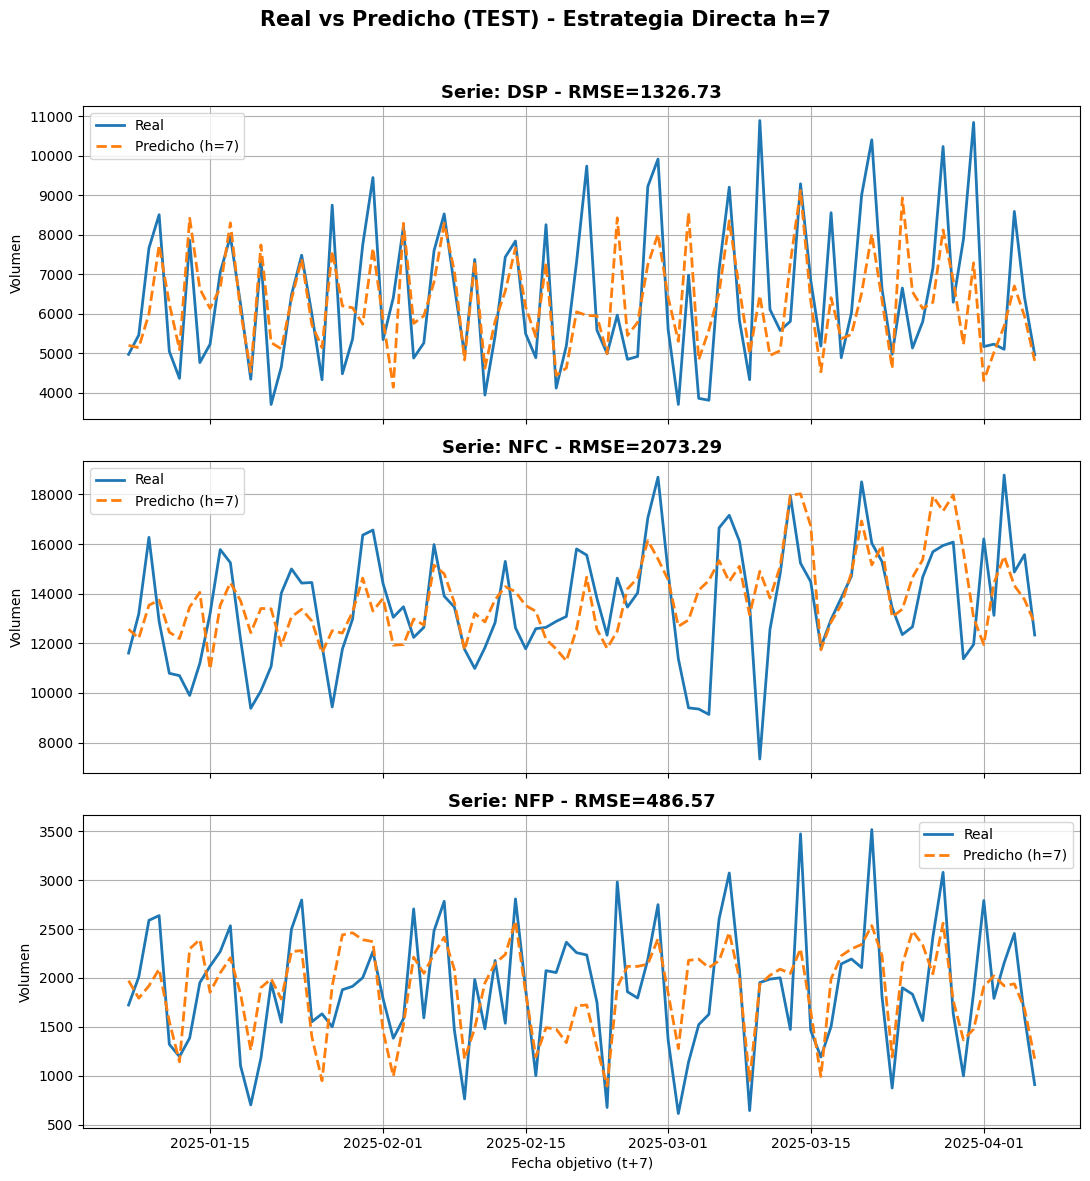

In [11]:
# Predicciones en test
yhat_te = final_model.predict(Xte)
print("\n=== MÉTRICAS GLOBALES (TEST, DIRECTO h=7) ===")

glob = metrics(yte.values, yhat_te)

for k, v in glob.items():
    print(f"{k}: {v:.4f}")

test_results = df_feat.loc[test_mask, [DATE_COL, "fecha_objetivo", "serie"]].copy()
test_results["y_real"] = yte.values
test_results["y_pred"] = yhat_te

# Métricas por serie
rows = []
for s, g in test_results.groupby("serie"):
    m = metrics(g["y_real"].values, g["y_pred"].values)
    m["serie"] = s
    rows.append(m)
df_metrics_series = pd.DataFrame(rows).sort_values("RMSE")
print("\n=== MÉTRICAS POR SERIE (TEST, DIRECTO h=7) ===")
print(df_metrics_series.reset_index(drop=True))

# Gráficos I
series_order = list(test_results["serie"].cat.categories)
n_series = len(series_order)
fig, axes = plt.subplots(n_series, 1, figsize=(11, 4*n_series), sharex=True)

if n_series == 1:
    axes = [axes]

for ax, s in zip(axes, series_order):
    g = test_results[test_results["serie"] == s].sort_values("fecha_objetivo")
    ax.plot(g["fecha_objetivo"], g["y_real"], label="Real", linewidth=2)
    ax.plot(g["fecha_objetivo"], g["y_pred"], label="Predicho (h=7)", linestyle="--", linewidth=2)
    # título con RMSE por serie
    rmse_s = df_metrics_series.loc[df_metrics_series["serie"] == s, "RMSE"].values
    rmse_txt = f" - RMSE={rmse_s[0]:.2f}" if len(rmse_s) else ""
    ax.set_title(f"Serie: {s}{rmse_txt}", fontsize=13, fontweight="bold")
    ax.set_ylabel("Volumen")
    ax.grid(True)
    ax.legend()

plt.xlabel("Fecha objetivo (t+7)")
plt.suptitle("Real vs Predicho (TEST) - Estrategia Directa h=7", fontsize=15, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [12]:
# CHECK fuga... ver con ChatGPT

print("\n[CHECK] Verificación de no-fuga temporal")

# -----------------------------
# 1) Splits: no solapamiento temporal por fecha_objetivo
# -----------------------------
mx_tr = df_feat.loc[train_mask, "fecha_objetivo"].max()
mn_va = df_feat.loc[val_mask,   "fecha_objetivo"].min()
mx_va = df_feat.loc[val_mask,   "fecha_objetivo"].max()
mn_te = df_feat.loc[test_mask,  "fecha_objetivo"].min()

assert mx_tr < mn_va, f"Leak: train (max={mx_tr}) toca / supera val (min={mn_va})"
assert mx_va < mn_te, f"Leak: val (max={mx_va}) toca / supera test (min={mn_te})"

print(f" OK splits: max(train)={mx_tr} < min(val)={mn_va} < max(val)={mx_va} < min(test)={mn_te}")

H_chk = 7
min_lag_chk = max(LAGS + ROLLS)  # 90

# Para cada serie, la última 'fecha' disponible en features debe estar al menos H días antes de la última en df_long
ok_trim = True
for s, g in df_feat.groupby("serie"):
    last_feat_date = g[DATE_COL].max()
    last_raw_date  = df_long.loc[df_long["serie"] == s, DATE_COL].max()
    if not (last_feat_date <= last_raw_date - pd.Timedelta(days=H_chk)):
        ok_trim = False
        print(f" WARN trim: serie={s} last_feat={last_feat_date} vs last_raw={last_raw_date} (esperado <= last_raw-H)")
assert ok_trim, "Trimming de horizonte H no se cumplió en alguna serie."
print(" OK trimming de H en features por serie.")

sample = df_feat.sample(n=min(200, len(df_feat)), random_state=123)  # muestra chica para acelerar

# Creamos lookup (serie, fecha) -> y
y_lookup = df_long.set_index(["serie", DATE_COL])["y"]

def get_y_at(serie, fecha):
    try:
        return float(y_lookup.loc[(serie, fecha)])
    except KeyError:
        return np.nan

lag_mismatches = []
for _, row in sample.iterrows():
    s = row["serie"]
    t = row[DATE_COL]
    for L in LAGS:
        col = f"lag_{L}"
        if col in df_feat.columns:
            expected = get_y_at(s, t - pd.Timedelta(days=L))
            got = row[col]
            # tolerancia numérica pequeña (NaNs se consideran OK si expected es NaN por borde)
            if pd.notna(expected) and pd.notna(got):
                if not np.isclose(expected, got, rtol=0, atol=1e-8):
                    lag_mismatches.append((s, t, col, expected, got))

assert len(lag_mismatches) == 0, f"Lags inconsistentes en {len(lag_mismatches)} filas de la muestra."
print(" OK lags: 'lag_L' coincide con y(t-L) en la muestra auditada.")

# Recalcular features sobre df_long (antes del trim), igual que al entrenar
df_recalc = add_calendar_features(df_long.copy())
df_recalc = add_lag_roll_features(df_recalc, lags=LAGS, rolls=ROLLS)
df_recalc = df_recalc.sort_values(["serie", DATE_COL])

# Preparamos un sample de filas a chequear (claves: serie, fecha)
sample_keys = sample[["serie", DATE_COL]].copy()

roll_mismatches = []
for W in ROLLS:
    col = f"roll_mean_{W}"

    # Traer el 'esperado' desde el recompute
    exp_w = df_recalc[["serie", DATE_COL, col]].rename(columns={col: f"expected_{col}"})
    chk = sample_keys.merge(
        df_feat[["serie", DATE_COL, col]],
        on=["serie", DATE_COL],
        how="left"
    ).merge(
        exp_w,
        on=["serie", DATE_COL],
        how="left"
    )

    # Comparar numéricamente (tol chica); NaN vs NaN se considera OK
    comp = chk[[col, f"expected_{col}"]].copy()
    same = (
        (comp[col].isna() & comp[f"expected_{col}"].isna()) |
        (comp[col].notna() & comp[f"expected_{col}"].notna() &
         np.isclose(comp[col].values, comp[f"expected_{col}"].values, rtol=0, atol=1e-8))
    )
    bad = chk.loc[~same, ["serie", DATE_COL, col, f"expected_{col}"]]
    if not bad.empty:
        for r in bad.itertuples(index=False):
            roll_mismatches.append((r.serie, r.fecha, col, r._3, r._4))  # (serie, fecha, col, got, expected)

assert len(roll_mismatches) == 0, f"Rollings inconsistentes en {len(roll_mismatches)} filas de la muestra."
print(" OK rollings: columnas 'roll_mean_W' coinciden exactamente con el recompute vectorizado.")
# Chequeo blando: no debería existir 'eval_set' con (Xte,yte) en el fit final
print(" OK entrenamiento final: no se empleó (Xte,yte) para early stopping.\nTodo limpio ✅")


[CHECK] Verificación de no-fuga temporal
 OK splits: max(train)=2024-10-08 00:00:00 < min(val)=2024-10-09 00:00:00 < max(val)=2025-01-06 00:00:00 < min(test)=2025-01-07 00:00:00
 OK trimming de H en features por serie.
 OK lags: 'lag_L' coincide con y(t-L) en la muestra auditada.
 OK rollings: columnas 'roll_mean_W' coinciden exactamente con el recompute vectorizado.
 OK entrenamiento final: no se empleó (Xte,yte) para early stopping.
Todo limpio ✅


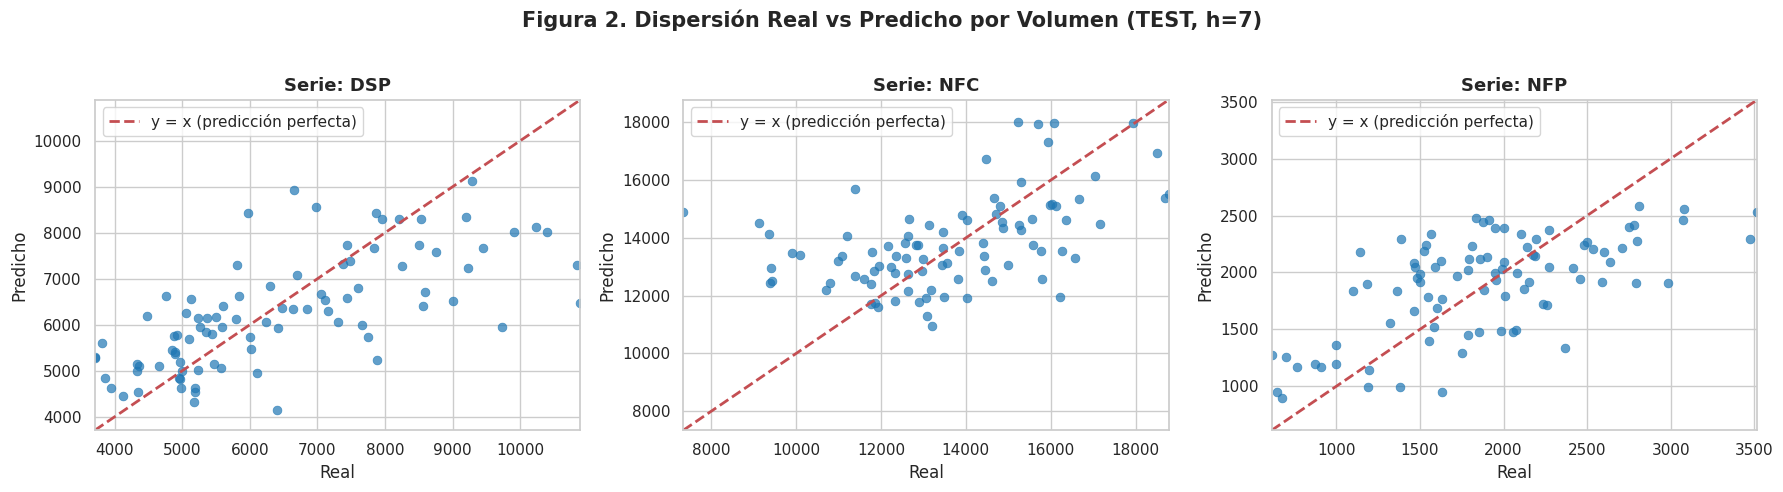

In [13]:
# Check fuga Gemini???

# Graficos II
import seaborn as sns
sns.set(style="whitegrid")

# Crear un scatter plot por serie
n_series = len(series_order)
fig, axes = plt.subplots(1, n_series, figsize=(6*n_series, 5), sharex=False, sharey=False)

if n_series == 1:
    axes = [axes]

for ax, s in zip(axes, series_order):
    g = test_results[test_results["serie"] == s]
    sns.scatterplot(x="y_real", y="y_pred", data=g, ax=ax, color="tab:blue", s=40, alpha=0.7, edgecolor=None)
    # Línea diagonal ideal (predicción perfecta)
    lims = [
        np.min([g["y_real"].min(), g["y_pred"].min()]),
        np.max([g["y_real"].max(), g["y_pred"].max()])
    ]
    ax.plot(lims, lims, 'r--', lw=2, label="y = x (predicción perfecta)")
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_xlabel("Real")
    ax.set_ylabel("Predicho")
    ax.set_title(f"Serie: {s}", fontsize=13, fontweight="bold")
    ax.legend()

plt.suptitle("Figura 2. Dispersión Real vs Predicho por Volumen (TEST, h=7)",
             fontsize=15, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
